In [32]:
from sklearn.svm import LinearSVC
from sklearn import preprocessing
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
# read names that have provided survey eye color data
columns = ['name', 'timestamp', 'id', 'blood_type', 'height', 'weight', 'hw_comments', 'left', 'right', 'left_desc', 'right_desc', 'eye_comments', 'hair', 'hair_desc', 'hair_comments', 'misc', 'handedness']

# pgp eye color data from survey
surveyData = pd.read_csv("./eye_color_data/PGP-Survey.csv", names=columns, na_values=['nan', '', 'NaN'])

# names of the pgp participants
surveyNames = np.asarray(surveyData['name'].values.tolist())

In [34]:
# load numpy array of names and keep only the huID
pgpNames = np.load("names")
for i in range(len(pgpNames)):
    pgpNames[i] = pgpNames[i][:8]

# load numpy array of tiled PGP data 
pgp = preprocessing.scale(np.load("hiq-pgp").astype('double'))

# simple lambda function to return if the input is a string
isstr = lambda val: isinstance(val, str)

In [35]:
# lookup a name in the survey data and return a tuple of the eye colors
def getAllData(name, surveyData):
    for index, row in surveyData.iterrows():
        if row['name'] == name:
            return (row['left'], row['right'])

In [36]:
# lookup a name in the survey data and return a tuple of the eye colors, excluding hazel
def getDataNoHazel(name, surveyData):
    for index, row in surveyData.iterrows():
        if row['name'] == name:
            if isstr(row['left_desc']) and isstr(row['right_desc']):
                if 'azel' in row['left_desc'] or 'azel' in row['right_desc']:
                    return None
            return (row['left'], row['right'])

In [37]:
# list of tuples for index and name with eye color data (idx, name)
namePairIndices = []

# dictionary of left and right eye colors with respective name, i.e., {"huID": 12}
leftEyeMap = {}
rightEyeMap = {}

existingNames = []

# loop through pgpNames and add eye color to maps, making sure not to add the same name twice
for i, name in enumerate(pgpNames):
    if name in surveyNames and name not in existingNames:
        existingNames.append(name)
        eyeData = getDataNoHazel(name, surveyData)
        if eyeData == None:
            continue
        leftEye, rightEye = eyeData
        if isstr(leftEye) and isstr(rightEye):
            namePairIndices.append((i, name))
            leftEyeMap[name] = leftEye
            rightEyeMap[name] = rightEye

# create lists containing the known eye color names and the unknown eye colors.
nameIndices = [nameIndex[0] for nameIndex in namePairIndices]
correspondingNames = [nameIndex[1] for nameIndex in namePairIndices]
knownData = pgp[nameIndices]
unknownData = np.delete(pgp, nameIndices, axis=0)

In [38]:
# convert dictionaries to lists 
leftEyeNameList = []
rightEyeNameList = []
# nametuple looks like (index, name)
for _, name in namePairIndices:
    if isstr(leftEyeMap[name]):
        leftEyeNameList.append(leftEyeMap[name])
    if isstr(rightEyeMap[name]):
        rightEyeNameList.append(rightEyeMap[name])

def blueOrNot(name):
    if isstr(name) and int(name) > 13:
        return 0 # not blue
    elif isstr(name):
        return 1 # blue 
    
leftEyeNameList = map(blueOrNot, leftEyeNameList)

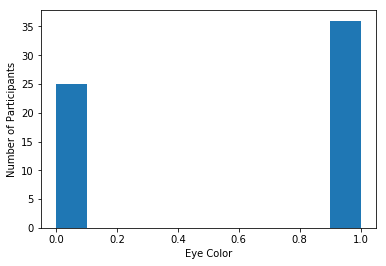

In [39]:
# create histogram of blue/not blue. TODO: make labels for graph
plt.hist(leftEyeNameList)
plt.ylabel("Number of Participants")
plt.xlabel("Eye Color")
plt.show()

In [40]:
# dump the classifier for analysis
from sklearn.externals import joblib
svc_test = LinearSVC(penalty='l1', class_weight='balanced', 
                     C=.06, dual=False, verbose=1, max_iter=2500)
svc_test.fit(knownData, leftEyeNameList)

[LibLinear]

LinearSVC(C=0.06, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2500,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=1)

In [41]:
joblib.dump(svc_test, "svc.pkl")

['svc.pkl']